In [1]:
import pickle
import numpy as np
from numpy import array
from pathlib import Path
from numpy.random import random, permutation, randn, normal, uniform, choice
from keras import applications
from keras.models import Sequential
from keras.layers import Input, Embedding, Reshape, merge, LSTM, Bidirectional
from keras.layers import TimeDistributed, Activation, SimpleRNN, GRU
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils.data_utils import get_file
from keras.utils import to_categorical
from keras.preprocessing import image, sequence, text
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
import sklearn.manifold
import pandas as pd
import re

Using TensorFlow backend.


# Pre-trained vectors

### we download pretrained word vectors trained on 6 billion tokens

In [2]:
# download the glove vectors from here https://github.com/stanfordnlp/GloVe and place the data in glove_dir. 
#Choose glove.6B.zip

glove_dir = '/home/ubuntu/glove/'
glove_file = 'glove.6B.50d'
glove_path = glove_dir + glove_file + '.txt'

with open(glove_path) as myfile:
    head = [next(myfile) for x in range(3)]
print(head[0])


the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581



In [3]:
# create vocab from the GloVe embedding file

words_pkl = glove_dir + glove_file + '.wpkl'
vecs_pkl = glove_dir + glove_file + '.vpkl'
wordidx_pkl = glove_dir + glove_file + '.ipkl'

def create_glove_vocab(path, w_pkl, v_pkl, i_pkl):
    words = []
    wordidx = {}
    emb_vecs = {}
    
    with open(path, 'r') as f:
        i = 0
        for line in f.readlines():
            data = line.strip().split(' ')
            words.append(data[0])
            wordidx[data[0]] = i
            emb_vecs[i] = np.asarray([float(val) for val in data[1:]])         
            i += 1
    
    vecs = np.stack((v for k, v in emb_vecs.items()),axis=1)
    vecs = vecs.transpose()
    
    with open(w_pkl, 'wb') as f1:
        pickle.dump(words, f1, pickle.HIGHEST_PROTOCOL)
        print("created word file")
        
    with open(v_pkl, 'wb') as f2:
        pickle.dump(vecs, f2, pickle.HIGHEST_PROTOCOL)
        print("created word vector file")
        
    with open(i_pkl, 'wb') as f3:
        pickle.dump(wordidx, f3, pickle.HIGHEST_PROTOCOL)
        print("created word index file")
    
    return vecs, words, wordidx

In [4]:
if Path(words_pkl).is_file() and Path(vecs_pkl).is_file() and Path(wordidx_pkl).is_file():
    print("found files")
    with open(words_pkl, 'rb') as f1:
        words = pickle.load(f1)
        print("loaded vocab file")
        
    with open(vecs_pkl, 'rb') as f2:
        vecs = pickle.load(f2)
        print("loaded embed file")
        
    with open(wordidx_pkl, 'rb') as f3:
        wordidx = pickle.load(f3)
        print("loaded index file")
        
else:
    vecs, words, wordidx = create_glove_vocab(glove_path, words_pkl, vecs_pkl, wordidx_pkl)

found files
loaded vocab file
loaded embed file
loaded index file


In [5]:
words[:10]

['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s"]

In [6]:
vecs.shape

(400001, 50)

In [7]:
vocab_range = 20000
short_vecs = vecs[:vocab_range]
short_vecs.shape

(20000, 50)

In [8]:
short_words = words[:vocab_range]
len(short_words)
short_words[:4]

['the', ',', '.', 'of']

## Visualizing word vectors

In [9]:
#squash dimensionality to 2

tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [10]:
tsne20000_pkl = glove_dir + glove_file + '.t20pkl'
print(tsne20000_pkl)

/home/ubuntu/glove/glove.6B.50d.t20pkl


In [11]:
#train t sne
if Path(tsne20000_pkl).is_file():
    print("found tsne 20000 files")
    with open(tsne20000_pkl, 'rb') as f:
        all_word_vectors_matrix_2d = pickle.load(f)
        print("loaded tsne 20000 file")
else:
    all_word_vectors_matrix_2d = tsne.fit_transform(short_vecs)
    with open(tsne20000_pkl, 'wb') as f:
        pickle.dump(all_word_vectors_matrix_2d, f, pickle.HIGHEST_PROTOCOL)
        print("created tsne 20000 file")

found tsne 20000 files
loaded tsne 20000 file


In [12]:
all_word_vectors_matrix_2d.shape

(20000, 2)

In [13]:
print(all_word_vectors_matrix_2d[wordidx['man']])

[-21.937641 -24.23339 ]


In [14]:
%matplotlib inline

In [15]:
#plot point in 2d space
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[wordidx[word]])
            for word in short_words
        ]
    ],
    columns=["word", "x", "y"]
)

In [16]:
points.head(3)

,word,x,y
0,the,-3.015991,16.009724
1,",",-3.691411,17.100885
2,.,-3.989955,16.942801


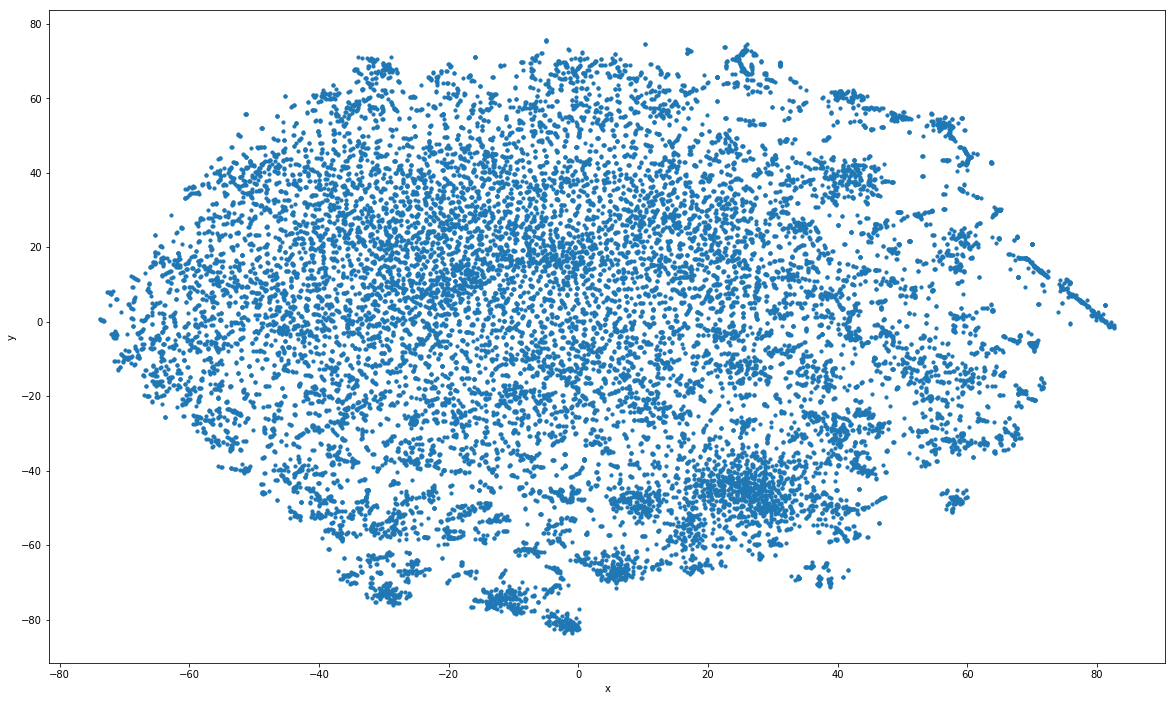

In [17]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [18]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

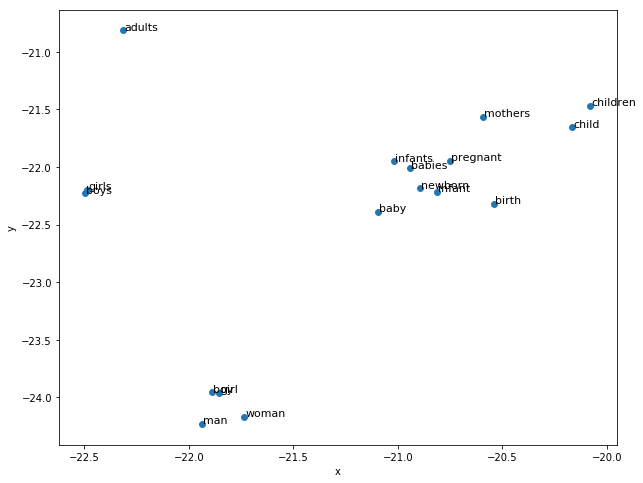

In [19]:
plot_region(x_bounds=(-22.5, -20.0), y_bounds=(-24.5, -20.8))

# Sentiment analysis of imdb movie reviews

## Get data from keras

In [20]:
train_file= '/home/ubuntu/Best/train.ft.txt'
test_file= '/home/ubuntu/Best/test.ft.txt'

In [21]:
train_o= open(train_file, 'r')
test_o= open(test_file, 'r')

In [22]:
train = train_o.readlines()
test = test_o.readlines()

In [23]:
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train]

for i in range(len(train_sentences)):
    train_sentences[i] = re.sub('\d','0',train_sentences[i])
    
test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test]
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test]

for i in range(len(test_sentences)):
    test_sentences[i] = re.sub('\d','0',test_sentences[i])
                                                       

In [24]:
for i in range(len(train_sentences)):
    if 'www.' in train_sentences[i] or 'http:' in train_sentences[i] or 'https:' in train_sentences[i] or '.com' in train_sentences[i]:
        train_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_sentences[i])
        
for i in range(len(test_sentences)):
    if 'www.' in test_sentences[i] or 'http:' in test_sentences[i] or 'https:' in test_sentences[i] or '.com' in test_sentences[i]:
        test_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", test_sentences[i])

In [25]:
max_words = 10000
#max_len = 500

In [26]:
tokenizer = text.Tokenizer(num_words=max_words)

In [27]:
tokenizer.fit_on_texts(train_sentences)

In [28]:
train_token = tokenizer.texts_to_sequences(train_sentences)
type(train_token)

list

In [29]:
train_token[0]

[74,
 11,
 1,
 610,
 6395,
 8,
 176,
 485,
 13,
 364,
 6,
 6071,
 1,
 10,
 60,
 438,
 27,
 69,
 3,
 39,
 1835,
 6,
 74,
 5,
 135,
 72,
 678,
 145,
 119,
 3,
 20,
 524,
 1,
 145,
 1870,
 16,
 40,
 7,
 28,
 7,
 1,
 597,
 3,
 20,
 132,
 524,
 6,
 44,
 1,
 88,
 119,
 6,
 6682,
 240,
 37,
 5109,
 2,
 422,
 4,
 851,
 17,
 8995,
 3028,
 2,
 4338,
 6,
 39,
 5209,
 207,
 72,
 2728,
 5,
 336]

In [30]:
test_token = tokenizer.texts_to_sequences(test_sentences)

In [31]:
#batch_size = 2048
epochs = 2

### we limit the vocab size and all less common words are  clubbed together

In [32]:
vocab_size = 8000

In [33]:
trn = [np.array([i if i<vocab_size-1 else vocab_size-1 for i in s]) for s in train_token]
test = [np.array([i if i<vocab_size-1 else vocab_size-1 for i in s]) for s in test_token]

In [34]:
max(map(len,trn))

254

In [35]:
min(map(len,trn))

0

In [36]:
from statistics import mean
mean(map(len,trn))

75.43316833333333

### we truncate the reviews to max 500 words. We need to pad the reviews which are shorter so that we have uniform length inputs to feed to the model

In [43]:
seq_len = 500
X_train = sequence.pad_sequences(trn, maxlen=seq_len)
X_test = sequence.pad_sequences(test, maxlen=seq_len)

In [44]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

## Lets build our models with different parameters

### 1st & 2nd models - we choose default keras embedding which is uniform distribution. The difference between the two is the size of the embeddings

In [45]:
embed_dim = 32

In [46]:
from keras.layers import CuDNNLSTM
model1 = Sequential([
    Embedding(vocab_size, embed_dim, input_length=seq_len),
    CuDNNLSTM(100),
    Dense(1, activation='sigmoid')])
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           256000    
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 100)               53600     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 309,701
Trainable params: 309,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Train the model
model1.fit(X_train, train_labels, validation_data=(X_test, test_labels), epochs=1, batch_size=4096) 

Train on 3600000 samples, validate on 400000 samples
Epoch 1/1
1507328/3600000 [===========>..................] - ETA: 8:41 - loss: 0.2359 - acc: 0.9070

In [ ]:
embed_dim = 50
model2 = Sequential([
    Embedding(vocab_size, embed_dim, input_length=seq_len),
    CuDNNLSTM(100),
    Dense(1, activation='sigmoid')])
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

In [ ]:
#Train the model
model2.fit(trn, labels_train, validation_data=(test, labels_test), epochs=1, batch_size=4096) 

### In the 3rd model we choose the inital word embeddings from the pre trained word vectors

In [63]:
def create_emb():
    n_fact = vecs.shape[1]
    emb = np.zeros((vocab_size, n_fact))
    new_word_count = 0
    nw_idx = []
    new_words = []
    for i in range(1, vocab_size):
        word = idx2word[i]
        if word in words:
            src_idx = wordidx[word]
            emb[i] = vecs[src_idx]
        else:
            # If we can't find the word in glove, randomly initialize
            emb[i] = normal(scale=0.6, size=(n_fact,))
            new_word_count += 1
            nw_idx.append(i)
            new_words.append(word)

    # This is our "rare word" id - we want to randomly initialize
    emb[-1] = normal(scale=0.6, size=(n_fact,))
    emb/=3
    return emb, new_word_count, nw_idx, new_words      

In [64]:
emb, new_word_count, nw_idx, new_words = create_emb()

In [65]:
new_word_count

79

In [67]:
embed_dim = emb.shape[1]

In [68]:
model3 = Sequential([
    Embedding(vocab_size, embed_dim, weights=[emb], input_length=seq_len),
    CuDNNLSTM(100),
    Dense(1, activation='sigmoid')])
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 50)           250000    
_________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)     (None, 100)               60800     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 310,901
Trainable params: 310,901
Non-trainable params: 0
_________________________________________________________________


In [69]:
#Train the model
model3.fit(trn, labels_train, validation_data=(test, labels_test), epochs=1, batch_size=64) 

Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 38s 2ms/step - loss: 0.5549 - acc: 0.7131 - val_loss: 0.3802 - val_acc: 0.8344


#### Just run both models for one more epoch

In [70]:
#Train the model
model2.fit(trn, labels_train, validation_data=(test, labels_test), epochs=1, batch_size=64) 

Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 37s 1ms/step - loss: 0.3086 - acc: 0.8763 - val_loss: 0.3376 - val_acc: 0.8599


In [71]:
#Train the model
model3.fit(trn, labels_train, validation_data=(test, labels_test), epochs=1, batch_size=64) 

Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 37s 1ms/step - loss: 0.3511 - acc: 0.8523 - val_loss: 0.3226 - val_acc: 0.8669


#### it seems that model2 is the best

In [72]:
#Evaluate the model
scores = model3.evaluate(test, labels_test, verbose=0) 
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 86.69%


In [173]:
#predict sentiment from reviews
bad = "this movie was terrible and bad"
good = "i really liked the movie and had fun"
for review in [good,bad]:
    tmp = []
    for word in review.split(" "):
        tmp.append(idx[word])
    tmp_padded = sequence.pad_sequences([tmp], maxlen=seq_len) 
    print("%s. Sentiment: %s" % (review,model2.predict(array([tmp_padded][0]))[0][0]))

i really liked the movie and had fun. Sentiment: 0.915826
this movie was terrible and bad. Sentiment: 0.086991
